In [1]:
%matplotlib inline

from __future__ import division

import numpy as np
import h5py as h5
import time
import sys

# set warpoptions.ignoreUnknownArgs = True before main import to allow command line arguments
import warpoptions
warpoptions.ignoreUnknownArgs = True

from warp import *

path_to_rswarp = "/Users/yhu/Documents/Work/RadiaSoft/rswarp"
if not path_to_rswarp in sys.path: sys.path.insert(1, path_to_rswarp)
    
from copy import deepcopy
from random import randint
from rswarp.cathode import sources
from warp.data_dumping.openpmd_diag import ParticleDiagnostic
from rswarp.diagnostics import FieldDiagnostic
from rswarp.utilities.file_utils import cleanupPrevious
from rswarp.diagnostics.parallel import save_lost_particles
from rswarp.diagnostics.ConductorDiagnostics import analyze_scraped_particles

from rswarp.stlconductor.stlconductor import *

# Constants imports
from scipy.constants import e, m_e, c, k

# Set matplotlib backend for saving plots (if requested)
import matplotlib as mpl 
  
import matplotlib.pyplot as plt 
from matplotlib import colors
from matplotlib import cm as cmaps

kb_eV = 8.6173324e-5  # Bolztmann constant in eV/K
kb_J = k  # Boltzmann constant in J/K

m = m_e  # electron mass

# Warp
# Origin date: Fri, 5 Oct 2018 22:42:05 +0000
# Local date: Fri, 5 Oct 2018 22:42:05 +0000
# Commit hash: 8ade0910
# /Users/yhu/.pyenv/versions/2.7.14/envs/warp/lib/python2.7/site-packages/warp/warp.pyc
# /Users/yhu/.pyenv/versions/2.7.14/envs/warp/lib/python2.7/site-packages/warp/warpC.so
# Sun Feb 17 20:14:14 2019
# import warp time 0.539093971252 seconds
# For more help, type warphelp()


/Users/yhu/.pyenv/versions/2.7.14/envs/warp/lib/python2.7/site-packages/warp/warp.py:79: UserWarning: there was an error importing gist; if this is a problem, restart python and type 'import gist' for details, otherwise Warp will run OK but with no graphics
  warnings.warn("there was an error importing gist; if this is a problem, restart python and type 'import gist' for details, otherwise Warp will run OK but with no graphics")


In [2]:
############################
# Domain / Geometry / Mesh #
############################

PLATE_SPACING = 4000e-9                  # plate spacing
# CHNNEL_WIDTH_X is set like this to make sure periodic boundary is correct
CHANNEL_WIDTH_X = 802.941176470588e-9    # width of simulation box
CHANNEL_WIDTH_Y = 548.076782226562e-9    # width of simulation box

# Dimensions
X_MAX = +CHANNEL_WIDTH_X / 2.
X_MIN = -X_MAX
Y_MAX = +CHANNEL_WIDTH_Y / 2.
Y_MIN = -Y_MAX
Z_MAX = PLATE_SPACING
Z_MIN = 0.

# Grid parameters
# NUM_X = 128; NUM_Y = 88; NUM_Z = 640
NUM_X = 320; NUM_Y = 220; NUM_Z = 1600

# z step size
dx = (X_MAX - X_MIN)/NUM_X
dy = (Y_MAX - Y_MIN)/NUM_Y
dz = (Z_MAX - Z_MIN)/NUM_Z

# Solver Geometry and Boundaries

# Specify solver geometry
w3d.solvergeom = w3d.XYZgeom

# Set field boundary conditions
w3d.bound0 = neumann
w3d.boundnz = dirichlet
w3d.boundxy = periodic

# Particles boundary conditions
top.pbound0 = absorb
top.pboundnz = absorb
top.pboundxy = periodic

# Set mesh boundaries
w3d.xmmin = X_MIN
w3d.xmmax = X_MAX
w3d.ymmin = Y_MIN
w3d.ymmax = Y_MAX
w3d.zmmin = Z_MIN
w3d.zmmax = Z_MAX

# Set mesh cell counts
w3d.nx = NUM_X
w3d.ny = NUM_Y
w3d.nz = NUM_Z

In [3]:
###############################
# PARTICLE INJECTION SETTINGS #
###############################

injection_type = 1
cathode_temperature = 1273.15
cathode_workfunction = 2.0               # in eV
anode_workfunction = 0.1
volts_on_conductor = 15.

# INJECTION SPECIFICATION
USER_INJECT = injection_type

# Cathode and anode settings
CATHODE_TEMP = cathode_temperature
CATHODE_PHI = cathode_workfunction
ANODE_WF = anode_workfunction            # Can be used if vacuum level is being set
CONDUCTOR_VOLTS = volts_on_conductor     # ACCEL_VOLTS used for velocity and CL calculations

# Emitted species
# Emitter area and position
SOURCE_RADIUS_1 = 0.5 * CHANNEL_WIDTH_X  # a0 parameter - X plane
SOURCE_RADIUS_2 = 0.5 * CHANNEL_WIDTH_Y  # b0 parameter - Y plane
Z_PART_MIN = dz / 1000.                  # starting particle z value

# Compute cathode area for geomtry-specific current calculations
if (w3d.solvergeom == w3d.XYZgeom):
    # For 3D cartesion geometry only
    cathode_area = 4. * SOURCE_RADIUS_1 * SOURCE_RADIUS_2
else:
    # Assume 2D XZ geometry
    cathode_area = 2. * SOURCE_RADIUS_1 * 1.

# If using the XZ geometry, set so injection uses the same geometry
top.linj_rectangle = (w3d.solvergeom == w3d.XZgeom or w3d.solvergeom == w3d.XYZgeom)

PTCL_PER_STEP = 300
CURRENT_MODIFIER = 0.5                   # Factor to multiply CL current by when setting beam current

derivqty()

In [4]:
################
# FIELD SOLVER #
################

# Set up fieldsolver
f3d.mgtol = 1e-6
solverE = MultiGrid3D()
registersolver(solverE)

In [5]:
##########################
# CONDUCTOR INSTALLATION #
##########################

ofile_prefix = "honeycomb_dx{:.2f}".format(dz*1e9)
install_conductor = True

if install_conductor:
    conductor = STLconductor("../grid/honeycomb_thickness5nm.stl", verbose="on", voltage=CONDUCTOR_VOLTS, normalization_factor=dz, condid=1)

 ---  Ray-triangle intersection finding scheme selected: Watertight
 ---  STL conductor surface mesh: # of vertices and elements = (29040, 58320)
 ---  STL conductor surface mesh: extent -> (xmin,ymin,zmin)=(-4.55e-07,-2.74038391113e-07,2e-06), (xmax,ymax,zmax)=(4.55e-07,2.74038391113e-07,2.005e-06)
 ---  STL conductor surface mesh: triangle element angles -> (min,max,median)=(25.9673771788,112.380510827,57.9124818027) deg


In [6]:
# --- Anode Location
zplate = Z_MAX

# Create source conductors
if install_conductor:
    source = ZPlane(zcent=w3d.zmmin, zsign=-1., voltage=0., condid=2)
else:
    source = ZPlane(zcent=w3d.zmmin, zsign=-1., voltage=0.)

# Create ground plate
if install_conductor:
    plate = ZPlane(voltage=0., zcent=zplate, condid=3)
else:
    plate = ZPlane(voltage=volts_on_conductor, zcent=zplate)

In [7]:
if install_conductor :
    installconductor(conductor, dfill=largepos)
    installconductor(source, dfill=largepos)
    installconductor(plate, dfill=largepos)
#     scraper = ParticleScraper([accel_grid, source, plate],
#                               lcollectlpdata=True,
#                               lsaveintercept=True)
#     scraper_dictionary = {1: 'grid', 2: 'source', 3: 'collector'}
    scraper = ParticleScraper([source, plate],
                              lcollectlpdata=True,
                              lsaveintercept=True)
    scraper_dictionary = {1: 'source', 2: 'collector'}
else:
    installconductor(source, dfill=largepos)
    installconductor(plate, dfill=largepos)
    scraper = ParticleScraper([source, plate])
    scraper_dictionary = {1: 'source', 2: 'collector'}

In [8]:
####################
# CONTROL SEQUENCE #
####################

# prevent gist from starting upon setup
top.lprntpara = false
top.lpsplots = false

top.verbosity = 1      # Reduce solver verbosity
solverE.mgverbose = 1  # further reduce output upon stepping - prevents websocket timeouts in Jupyter notebook

init_iters = 20000
regular_iters = 200

init_tol = 1e-6
regular_tol = 1e-6

# Time Step

# initialize field solver and potential field
solverE.mgmaxiters = init_iters
solverE.mgtol = init_tol
package("w3d")
generate()

step(1)

 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments
 ---  generating intercepts for mglevel = 0
 ---  (nx,ny,nz)=(320,220,4), (dx,dy,dz)=(1.00367647059,0.996503240412,1.0)
 ---  boxlo=(-160.588235294,-109.615356445,799.0), boxhi=(160.588235294,109.615356445,803.0)
 ---  surface_boxlo=(-182.0,-109.615356445,800.0), surface_boxhi=(182.0,109.615356445,802.0)
 ---  generating xintercepts ...
 ---  generating yintercepts ...
 ---  generating zintercepts ...
 ---  generating intercepts for mglevel = 1
 ---  (nx,ny,nz)=(160,110,3), (dx,dy,dz)=(2.00735294118,1.99300648082,2.0)
 ---  boxlo=(-160.588235294,-109.615356445,798.0), boxhi=(160.588235294,109.615356445,804.0)
 ---  surface_boxlo=(-182.0,-109.615356445,800.0), surface_boxhi=(182.0,109.615356445,802.0)
 ---  generating xi

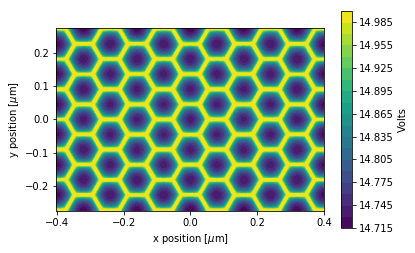

<Figure size 432x288 with 0 Axes>

In [9]:
###############
# DIAGNOSTICS #
###############

phi = solverE.getphi()
E = np.sqrt(solverE.getez() ** 2 + solverE.getex() ** 2 + solverE.getey() ** 2)

# xy-plane at z = zcent
grid_z = 2.000e-6
grid_iz = int((grid_z-Z_MIN)/dz)

x = np.linspace(X_MIN,X_MAX,NUM_X+1)*1e6
y = np.linspace(Y_MIN,Y_MAX,NUM_Y+1)*1e6
z = np.linspace(Z_MIN,Z_MAX,NUM_Z+1)*1e6

X, Y = np.meshgrid(x,y,indexing='ij')
  
plt.figure()

plt.contourf(X,Y,phi[:,:,grid_iz],20,cmap = cmaps.viridis)
plt.colorbar(label = 'Volts')

plt.xlabel(r'x position [$\mu$m]')
plt.ylabel(r'y position [$\mu$m]')
ax = plt.gca()
ax.set_aspect(1)
plt.show()
plt.savefig(ofile_prefix+"_potential.png", dpi=200)

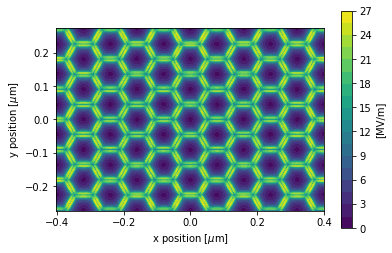

<Figure size 432x288 with 0 Axes>

In [10]:
# phi profile along z for (x=xcent, y=ycent)
plt.figure()
plt.contourf(X,Y,E[:,:,grid_iz]*1e-6,20,cmap = cmaps.viridis)
plt.xlabel(r'x position [$\mu$m]')
plt.ylabel(r'y position [$\mu$m]')
plt.colorbar(label = '[MV/m]')
ax = plt.gca()
ax.set_aspect(1)
plt.show()
plt.savefig(ofile_prefix+"_efield.png", dpi=200)

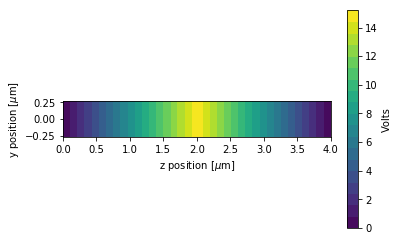

In [17]:
# yz-plane at x = xcent
grid_x  = X_MIN + CHANNEL_WIDTH_X*0.5
grid_ix = int((grid_x-X_MIN)/dx)
grid_y  = Y_MIN + CHANNEL_WIDTH_Y*0.5
grid_iy = int((grid_y-Y_MIN)/dy)

Z, Y = np.meshgrid(z,y)
plt.figure()
plt.contourf(Z, Y, phi[grid_ix,:,:],20,cmap = cmaps.viridis)
plt.xlabel(r'z position [$\mu$m]')
plt.ylabel(r'y position [$\mu$m]')
clim = [0., CONDUCTOR_VOLTS]
plt.clim(clim[0], clim[1])
plt.colorbar(label = 'Volts', ticks = np.arange(clim[0], clim[1]+1e-10, 2))
plt.gca().set_aspect(1)
plt.show()

In [12]:
# save potential and electric field to file
np.save("phi_cad_gridded_tec.npy", phi); np.save("E_cad_gridded_tec.npy", E)